<a href="https://colab.research.google.com/github/ltklinh1610/KTLT-ECO-GROUP/blob/main/Cu%E1%BB%91i%20K%C3%AC/CuoiKi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cuối Kì

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# KIỂM TRA DỮ LIỆU

In [2]:
import pandas as pd

df = pd.read_csv('Loan_default.csv')

print("=== THÔNG TIN TỔNG QUAN VÀ THỐNG KÊ MÔ TẢ (Describe All) ===")
print(df.describe())

print(f"Kích thước dữ liệu gốc: {df.shape}")
print("5 dòng đầu tiên:\n")
print(df.head(5))

print("\nKiểm tra Non-Null Count và Kiểu dữ liệu (Dữ liệu gốc):\n")
df.info()

=== THÔNG TIN TỔNG QUAN VÀ THỐNG KÊ MÔ TẢ (Describe All) ===
                 Age         Income     LoanAmount    CreditScore  \
count  255347.000000  255347.000000  255347.000000  255347.000000   
mean       43.498306   82499.304597  127578.865512     574.264346   
std        14.990258   38963.013729   70840.706142     158.903867   
min        18.000000   15000.000000    5000.000000     300.000000   
25%        31.000000   48825.500000   66156.000000     437.000000   
50%        43.000000   82466.000000  127556.000000     574.000000   
75%        56.000000  116219.000000  188985.000000     712.000000   
max        69.000000  149999.000000  249999.000000     849.000000   

       MonthsEmployed  NumCreditLines   InterestRate       LoanTerm  \
count   255347.000000   255347.000000  255347.000000  255347.000000   
mean        59.541976        2.501036      13.492773      36.025894   
std         34.643376        1.117018       6.636443      16.969330   
min          0.000000        1.00

# TIÊN XỬ LÝ DỮ LIỆU

In [3]:
CORE_COLUMNS = ['Default', 'Age', 'Income', 'LoanAmount', 'InterestRate', 'LoanTerm', 'EmploymentType', 'Education']
df_filtered = df[CORE_COLUMNS].copy()

# LẤY MẪU NGẪU NHIÊN (3% - 7661 quan sát)
sample_frac = 0.03
df_sample = df_filtered.sample(frac=sample_frac, random_state=42).copy()

# ĐỔI TÊN CỘT SANG TIẾNG VIỆT
df_sample.columns = ['Khả năng vỡ nợ', 'Tuổi', 'Thu nhập', 'Khoản vay', 'Lãi suất vay', 'Thời hạn vay', 'Nghề nghiệp', 'Trình độ học vấn']

# KIỂM TRA VÀ MÔ PHỎNG IMAPUTE (Data Cleaning)
# Dùng SimpleImputer để mô phỏng "Average/Most frequent"
numerical_cols = ['Tuổi', 'Thu nhập', 'Khoản vay', 'Lãi suất vay', 'Thời hạn vay']
categorical_cols = ['Nghề nghiệp', 'Trình độ học vấn']
imputer_numeric = SimpleImputer(strategy='mean')
imputer_categorical = SimpleImputer(strategy='most_frequent')

df_sample[numerical_cols] = imputer_numeric.fit_transform(df_sample[numerical_cols])
df_sample[categorical_cols] = imputer_categorical.fit_transform(df_sample[categorical_cols])

# CHUẨN HÓA BIẾN VÀ MÃ HÓA (Data Transformation)
# Chuẩn hóa nhị phân
df_sample['Trình độ học vấn_Binary'] = df_sample['Trình độ học vấn'].apply(
    lambda x: 1 if x in ['Master\'s', 'PhD'] else 0
)
df_sample['Nghề nghiệp_Binary'] = df_sample['Nghề nghiệp'].apply(
    lambda x: 0 if x == 'Unemployed' else 1
)

# Mã hóa One-Hot cho Phân loại
df_encoded = pd.get_dummies(df_sample,
                           columns=['Nghề nghiệp', 'Trình độ học vấn'],
                           prefix=['NgheNghiep', 'TrinhDo'])

print(f"Tiền xử lý hoàn tất. Kích thước DataFrame cuối cùng: {df_encoded.shape}")
print(df_encoded.describe())
print(df_encoded.head(5))

Tiền xử lý hoàn tất. Kích thước DataFrame cuối cùng: (7660, 16)
       Khả năng vỡ nợ         Tuổi       Thu nhập      Khoản vay  \
count     7660.000000  7660.000000    7660.000000    7660.000000   
mean         0.114099    43.643473   82187.606527  128188.430809   
std          0.317952    15.015183   38960.578710   70266.263950   
min          0.000000    18.000000   15053.000000    5034.000000   
25%          0.000000    31.000000   47669.500000   67511.500000   
50%          0.000000    44.000000   82043.500000  127778.000000   
75%          0.000000    57.000000  115600.250000  189781.500000   
max          1.000000    69.000000  149993.000000  249912.000000   

       Lãi suất vay  Thời hạn vay  Trình độ học vấn_Binary  Nghề nghiệp_Binary  
count   7660.000000   7660.000000              7660.000000         7660.000000  
mean      13.448431     35.772846                 0.495170            0.749739  
std        6.698524     16.979565                 0.500009            0.433192  


=== THỐNG KÊ MÔ TẢ (Biến số) ===
               count           mean     median           std       min  \
Tuổi          7660.0      43.643473      44.00     15.015183     18.00   
Thu nhập      7660.0   82187.606527   82043.50  38960.578710  15053.00   
Khoản vay     7660.0  128188.430809  127778.00  70266.263950   5034.00   
Lãi suất vay  7660.0      13.448431      13.46      6.698524      2.01   
Thời hạn vay  7660.0      35.772846      36.00     16.979565     12.00   

                   max  
Tuổi              69.0  
Thu nhập      149993.0  
Khoản vay     249912.0  
Lãi suất vay      25.0  
Thời hạn vay      60.0  


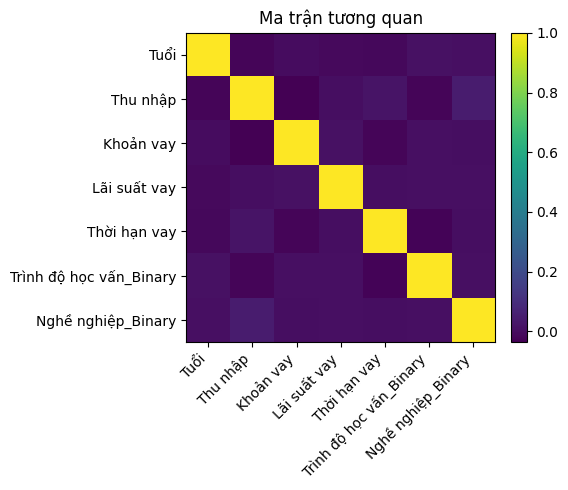

In [7]:
numerical_cols = ['Tuổi', 'Thu nhập', 'Khoản vay', 'Lãi suất vay', 'Thời hạn vay']

stats_numeric = df_sample[numerical_cols].agg(['count', 'mean', 'median', 'std', 'min', 'max']).T
print("\n=== THỐNG KÊ MÔ TẢ (Biến số) ===")
print(stats_numeric)

# === MA TRẬN TƯƠNG QUAN ===
corr_cols = numerical_cols + ['Trình độ học vấn_Binary', 'Nghề nghiệp_Binary']
corr_cols = [c for c in corr_cols if c in df_sample.columns]
corr = df_sample[corr_cols].corr(numeric_only=True)

plt.figure(figsize=(6, 5))
im = plt.imshow(corr, interpolation='nearest', cmap='viridis')
plt.title('Ma trận tương quan')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(ticks=range(len(corr_cols)), labels=corr_cols, rotation=45, ha='right')
plt.yticks(ticks=range(len(corr_cols)), labels=corr_cols)
plt.tight_layout()
plt.show()

# BƯỚC 3 PHÂN TÍCH MÔ TẢ


=== BƯỚC 3: PHÂN TÍCH MÔ TẢ (EDA) ===


/tmp/ipython-input-1151407005.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_sample, x=col_group, palette='tab10',
/tmp/ipython-input-1151407005.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_sample, x=col_group, palette='tab10',
/tmp/ipython-input-1151407005.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_sample, x=col_group, palette='tab10',
/tmp/ipython-input-1151407005.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.

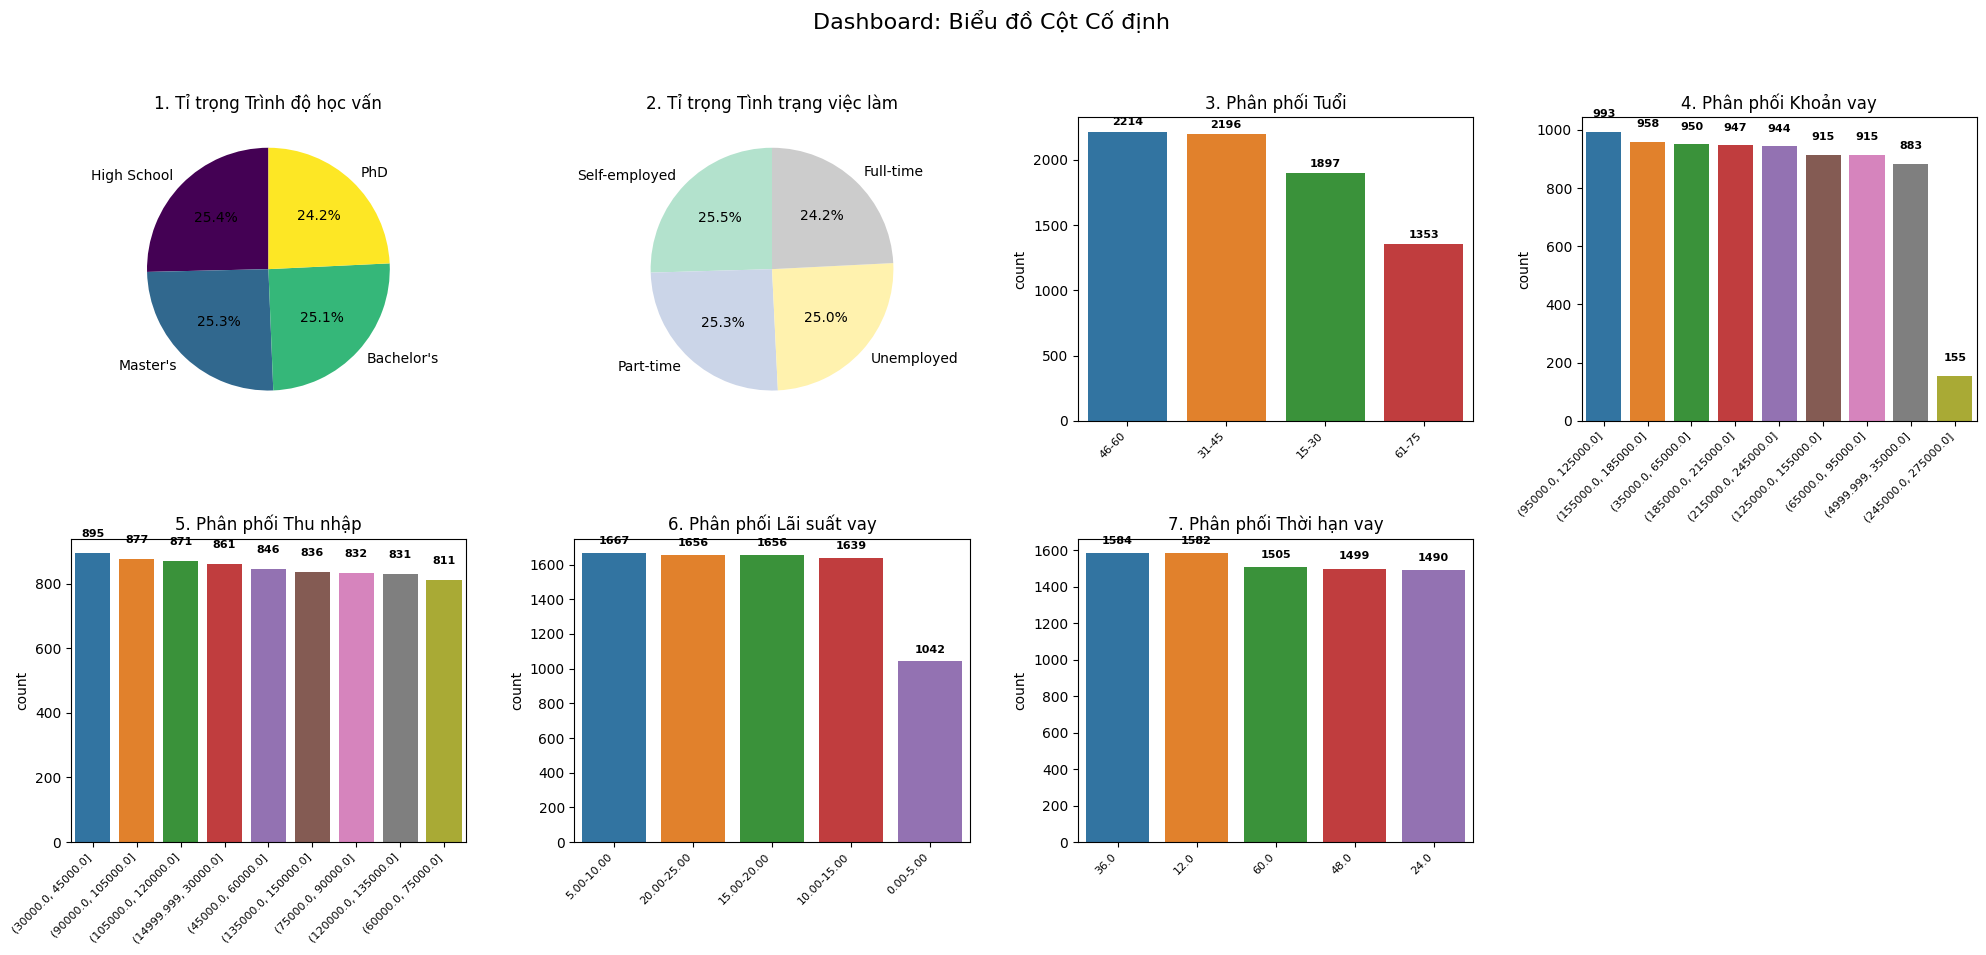


[Phân tích] Distribution theo Khả năng vỡ nợ (Sử dụng Biểu đồ Cột Stacked):


/tmp/ipython-input-1151407005.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_counts = df_sample.groupby([col_group, 'Khả năng vỡ nợ']).size().unstack(fill_value=0)


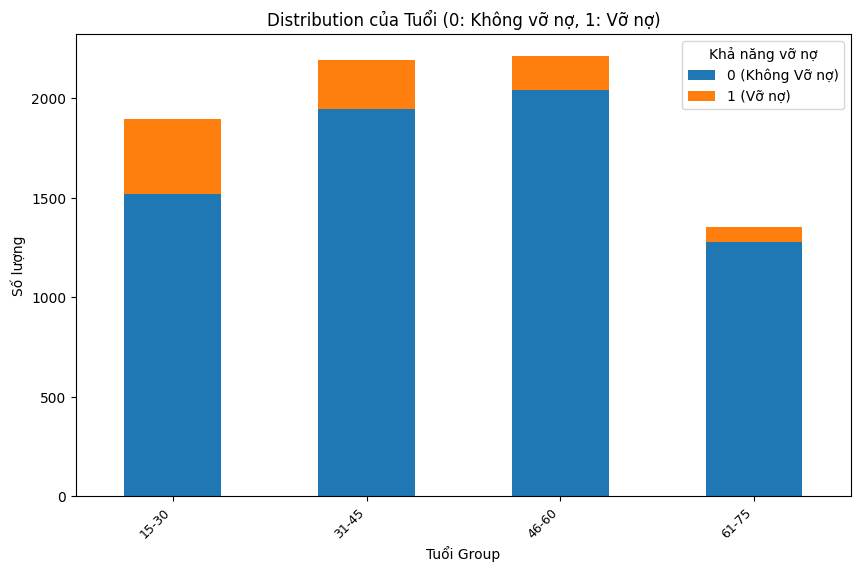

/tmp/ipython-input-1151407005.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_counts = df_sample.groupby([col_group, 'Khả năng vỡ nợ']).size().unstack(fill_value=0)


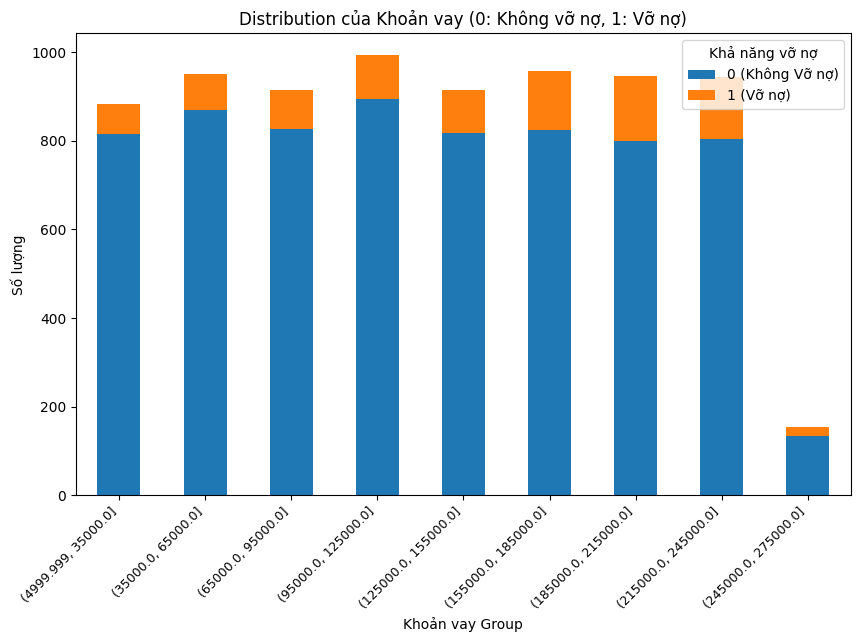

/tmp/ipython-input-1151407005.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_counts = df_sample.groupby([col_group, 'Khả năng vỡ nợ']).size().unstack(fill_value=0)


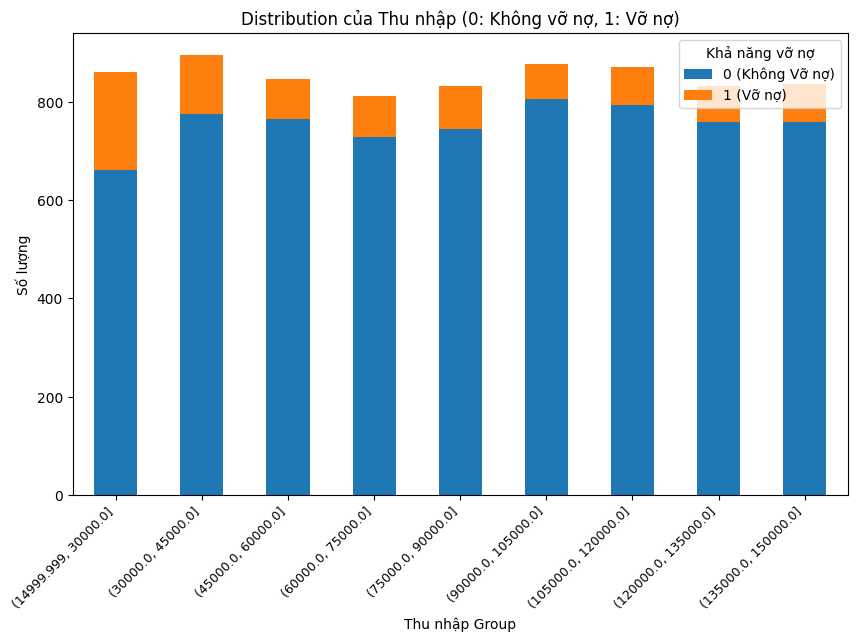

/tmp/ipython-input-1151407005.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_counts = df_sample.groupby([col_group, 'Khả năng vỡ nợ']).size().unstack(fill_value=0)


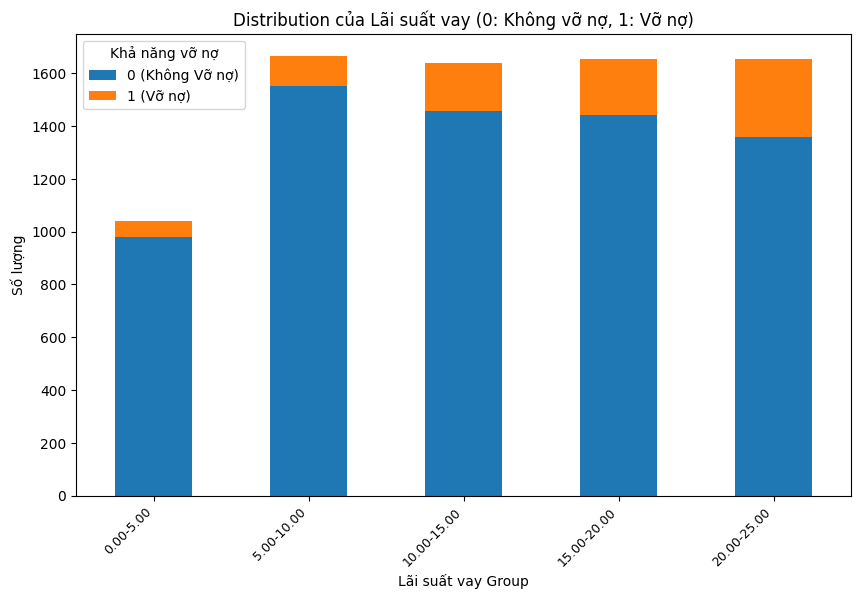

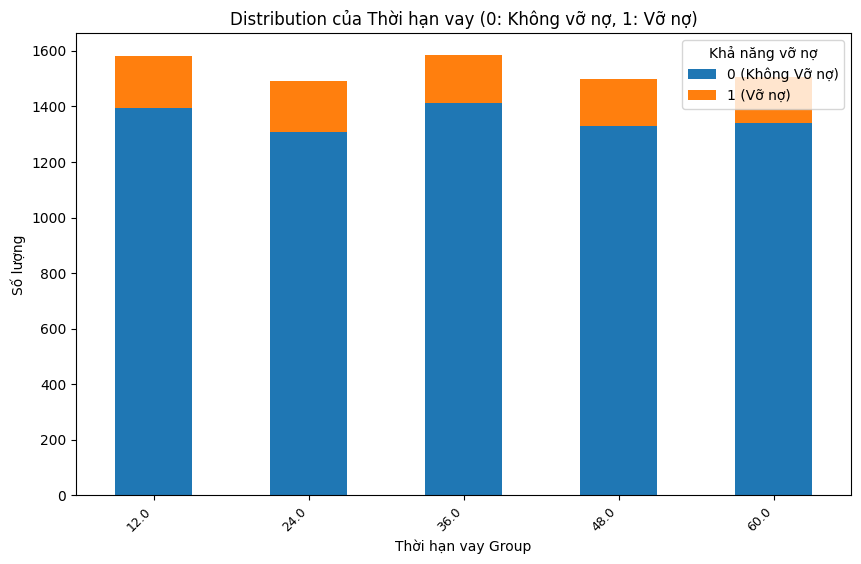

In [4]:
print("\n=== BƯỚC 3: PHÂN TÍCH MÔ TẢ (EDA) ===")
numerical_cols = ['Tuổi', 'Thu nhập', 'Khoản vay', 'Lãi suất vay', 'Thời hạn vay']

age_bins = [15, 30, 45, 60, 75]
age_labels = ['15-30', '31-45', '46-60', '61-75']
df_sample['Tuổi_Group'] = pd.cut(df_sample['Tuổi'], bins=age_bins, labels=age_labels, right=True, include_lowest=True)

loan_max = df_sample['Khoản vay'].max()
loan_bins = np.arange(5000, 275001, 30000)
df_sample['Khoản vay_Group'] = pd.cut(df_sample['Khoản vay'], bins=loan_bins, include_lowest=True)

income_max = df_sample['Thu nhập'].max()
income_bins = np.arange(15000, 155001, 15000)
df_sample['Thu nhập_Group'] = pd.cut(df_sample['Thu nhập'], bins=income_bins, include_lowest=True)

rate_bins = [0, 5, 10, 15, 20, 25]
rate_labels = ['0.00-5.00', '5.00-10.00', '10.00-15.00', '15.00-20.00', '20.00-25.00']
df_sample['Lãi suất vay_Group'] = pd.cut(df_sample['Lãi suất vay'], bins=rate_bins, labels=rate_labels, right=True, include_lowest=True)

df_sample['Thời hạn vay_Group'] = df_sample['Thời hạn vay'].astype(str)

plt.figure(figsize=(20, 10))
plt.suptitle('Dashboard: Biểu đồ Cột Cố định', fontsize=16)

grouped_cols = ['Tuổi_Group', 'Khoản vay_Group', 'Thu nhập_Group', 'Lãi suất vay_Group', 'Thời hạn vay_Group']
group_plot_positions = [3, 4, 5, 6, 7]

plt.subplot(2, 4, 1)
df_sample['Trình độ học vấn'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('1. Tỉ trọng Trình độ học vấn')
plt.ylabel('')

plt.subplot(2, 4, 2)
df_sample['Nghề nghiệp'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel2')
plt.title('2. Tỉ trọng Tình trạng việc làm')
plt.ylabel('')

for i, col_group in enumerate(grouped_cols):
    plt.subplot(2, 4, group_plot_positions[i])

    # Sử dụng Countplot để tạo Biểu đồ cột
    ax = sns.countplot(data=df_sample, x=col_group, palette='tab10',
                       order=df_sample[col_group].value_counts().index)
    plt.title(f'{group_plot_positions[i]}. Phân phối {col_group.split("_")[0]}')
    plt.xlabel('')
    plt.xticks(rotation=45, ha='right', fontsize=8)

    # Gắn nhãn số lượng lên trên các thanh bar
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 50,
                    '{:1.0f}'.format(height),
                    ha="center", fontsize=8, weight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


#PHÂN TÍCH ĐIỂM ĐẶC THÙ
print("\n[Phân tích] Distribution theo Khả năng vỡ nợ (Sử dụng Biểu đồ Cột Stacked):")

for col_group in grouped_cols:
    plt.figure(figsize=(10, 6))

    data_counts = df_sample.groupby([col_group, 'Khả năng vỡ nợ']).size().unstack(fill_value=0)
    data_counts.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=plt.gca())

    plt.title(f'Distribution của {col_group.split("_")[0]} (0: Không vỡ nợ, 1: Vỡ nợ)')
    plt.xlabel(col_group.replace('_', ' '))
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.legend(title='Khả năng vỡ nợ', labels=['0 (Không Vỡ nợ)', '1 (Vỡ nợ)'])
    plt.show()

# MÔ HÌNH PHÂN LỚP


=== BƯỚC 4: PHÂN LỚP VÀ DỰ ĐOÁN KHẢ NĂNG VỠ NỢ ===
Dữ liệu huấn luyện: (6128, 15), Dữ liệu dự báo (Test): (1532, 15)

--- Đánh giá Cây Quyết định (TREE) ---
Ma trận nhầm lẫn (Dựa trên 1532 quan sát):
[[1350    7]
 [ 167    8]]
  * Sai lầm loại 2 (FN): 167 (Lỗi nguy hiểm nhất)
  * Độ chính xác (Accuracy): 0.8864

--- Đánh giá Hồi quy Logistic ---
Ma trận nhầm lẫn (Dựa trên 1532 quan sát):
[[1355    2]
 [ 175    0]]
  * Sai lầm loại 2 (FN): 175 (Lỗi nguy hiểm nhất)
  * Độ chính xác (Accuracy): 0.8845

--- PHÂN TÍCH CHUYÊN SÂU HỒI QUY LOGISTIC (Hệ số tác động) ---
| Biến                     |   Hệ số (Coefficient) |
|:-------------------------|----------------------:|
| Lãi suất vay             |               1.39103 |
| Khoản vay                |               0.81000 |
| Thời hạn vay             |              -0.05840 |
| NgheNghiep_Part-time     |              -0.07204 |
| NgheNghiep_Self-employed |              -0.11501 |
| TrinhDo_PhD              |              -0.14015 |
| Trinh

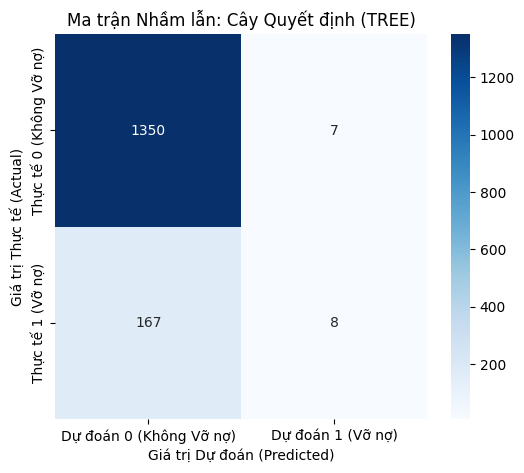

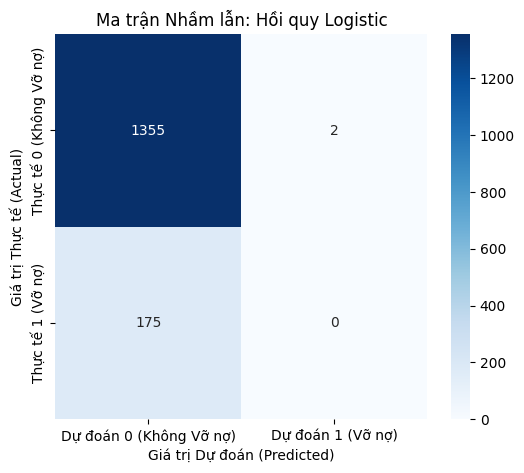


--- TRỰC QUAN HÓA CÂY QUYẾT ĐỊNH ---
Đã tạo file 'decision_tree.png' và hiển thị cấu trúc cây (giới hạn ở depth 3).


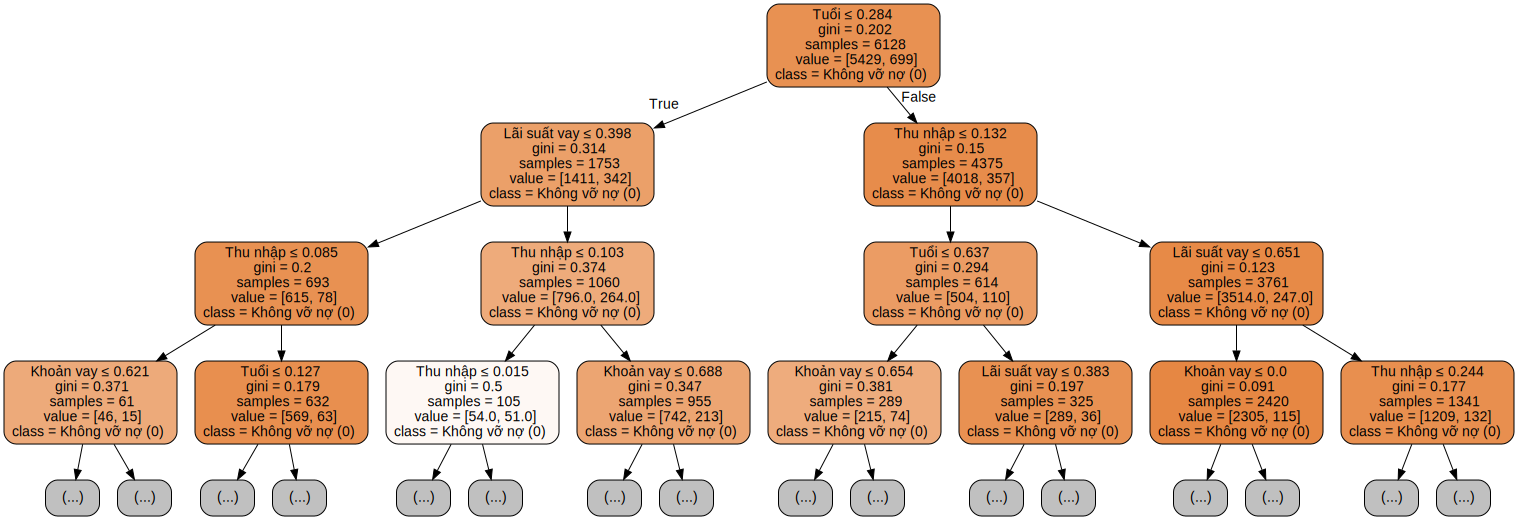

In [5]:
print("\n=== BƯỚC 4: PHÂN LỚP VÀ DỰ ĐOÁN KHẢ NĂNG VỠ NỢ ===")

# Chuẩn bị dữ liệu
numerical_cols_scaled = numerical_cols.copy()
X = df_encoded.drop(columns=['Khả năng vỡ nợ'])
y = df_encoded['Khả năng vỡ nợ']

# Scaling các biến số thực (cần thiết cho Logistic Regression)
scaler = MinMaxScaler()
X[numerical_cols_scaled] = scaler.fit_transform(X[numerical_cols_scaled])

# Chia dữ liệu huấn luyện (98%) và dữ liệu dự báo/kiểm tra (2%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Dữ liệu huấn luyện: {X_train.shape}, Dữ liệu dự báo (Test): {X_test.shape}")

def evaluate_and_print_cm(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, zero_division=0)

    fn_error = cm[1, 0]

    print(f"\n--- Đánh giá {model_name} ---")
    print(f"Ma trận nhầm lẫn (Dựa trên {len(y_true)} quan sát):\n{cm}")
    print(f"  * Sai lầm loại 2 (FN): {fn_error} (Lỗi nguy hiểm nhất)")
    print(f"  * Độ chính xác (Accuracy): {acc:.4f}")
    return acc, fn_error

# 1. Cây Quyết định (Decision Tree)
tree_model = DecisionTreeClassifier(random_state=42, max_depth=5)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
acc_tree, fn_tree = evaluate_and_print_cm(y_test, y_pred_tree, "Cây Quyết định (TREE)")

# 2. Hồi quy Logistic
log_model = LogisticRegression(solver='liblinear', random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
acc_log, fn_log = evaluate_and_print_cm(y_test, y_pred_log, "Hồi quy Logistic")

print("\n--- PHÂN TÍCH CHUYÊN SÂU HỒI QUY LOGISTIC (Hệ số tác động) ---")
coefficients = pd.DataFrame({
    'Biến': X_train.columns,
    'Hệ số (Coefficient)': log_model.coef_[0]
}).sort_values(by='Hệ số (Coefficient)', ascending=False)
print(coefficients.to_markdown(index=False, floatfmt=".5f"))

print("\nNhận xét: Hệ số dương (tăng nguy cơ vỡ nợ); Hệ số âm (giảm nguy cơ vỡ nợ).")
def plot_confusion_matrix(y_true, y_pred, model_name):
    """Vẽ Ma trận Nhầm lẫn dưới dạng Heatmap."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Dự đoán 0 (Không Vỡ nợ)', 'Dự đoán 1 (Vỡ nợ)'],
                yticklabels=['Thực tế 0 (Không Vỡ nợ)', 'Thực tế 1 (Vỡ nợ)'])

    plt.title(f'Ma trận Nhầm lẫn: {model_name}')
    plt.ylabel('Giá trị Thực tế (Actual)')
    plt.xlabel('Giá trị Dự đoán (Predicted)')
    plt.show()


# 1. Decision Tree
plot_confusion_matrix(y_test, y_pred_tree, "Cây Quyết định (TREE)")

# 2. Hồi quy Logistic
plot_confusion_matrix(y_test, y_pred_log, "Hồi quy Logistic")
from sklearn.tree import export_graphviz
import graphviz

# 1. Trích xuất cấu trúc cây sang định dạng DOT
dot_data = export_graphviz(tree_model,
                           feature_names=X_train.columns,
                           class_names=['Không vỡ nợ (0)', 'Vỡ nợ (1)'],
                           filled=True,
                           rounded=True,
                           special_characters=True,
                           max_depth=3)
graph = graphviz.Source(dot_data)
graph.render("decision_tree", view=False, format="png")

print("\n--- TRỰC QUAN HÓA CÂY QUYẾT ĐỊNH ---")
print("Đã tạo file 'decision_tree.png' và hiển thị cấu trúc cây (giới hạn ở depth 3).")
from IPython.display import display
display(graph)

# MÔ HÌNH PHÂN CỤM

Silhouette Score cho K=2: 0.1494
Silhouette Score cho K=3: 0.1393
Silhouette Score cho K=4: 0.1444
Silhouette Score cho K=5: 0.1450

[Phân tích] Trung bình các biến trong 2 cụm:
|   Cluster |   Tuổi |   Thu nhập |   Khoản vay |   Lãi suất vay |   Thời hạn vay |   Tỷ lệ Vỡ nợ (Avg) |
|----------:|-------:|-----------:|------------:|---------------:|---------------:|--------------------:|
|         0 |  44.45 |   48489.90 |   135140.21 |          13.33 |          34.90 |                0.14 |
|         1 |  42.84 |  115639.85 |   121287.29 |          13.57 |          36.64 |                0.09 |


<Figure size 1500x600 with 0 Axes>

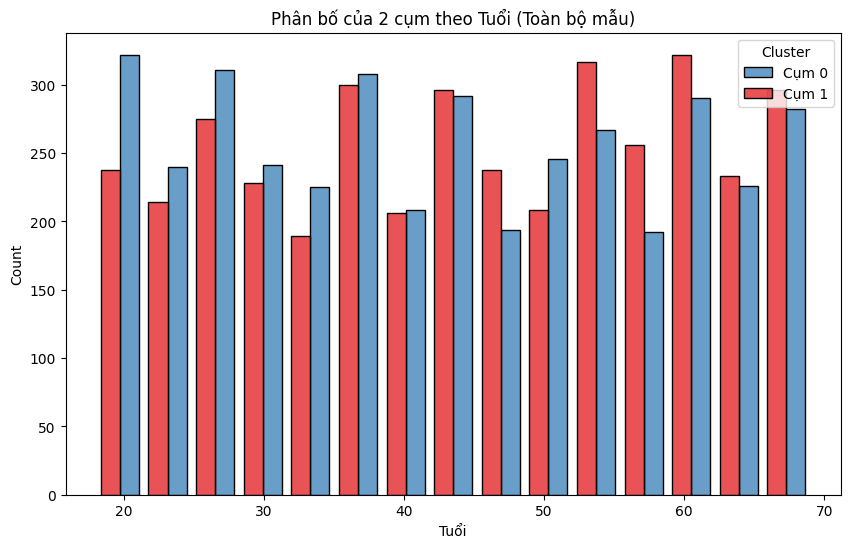

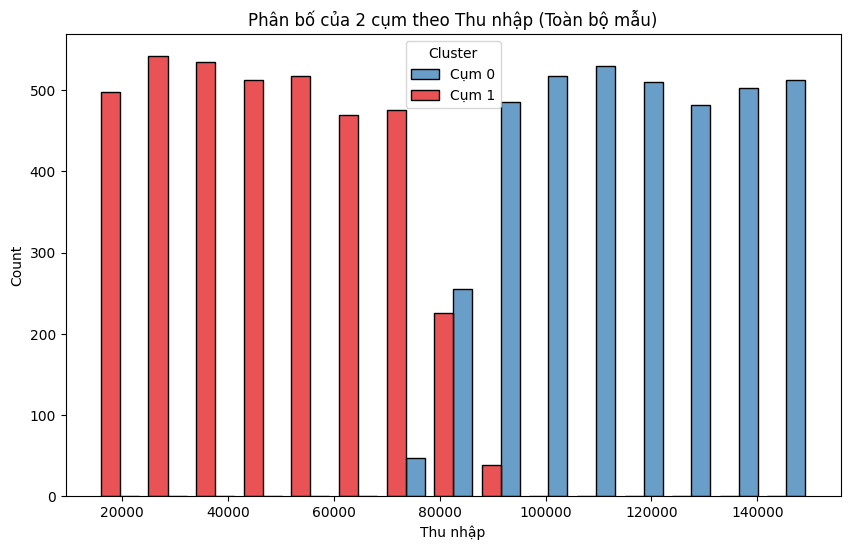

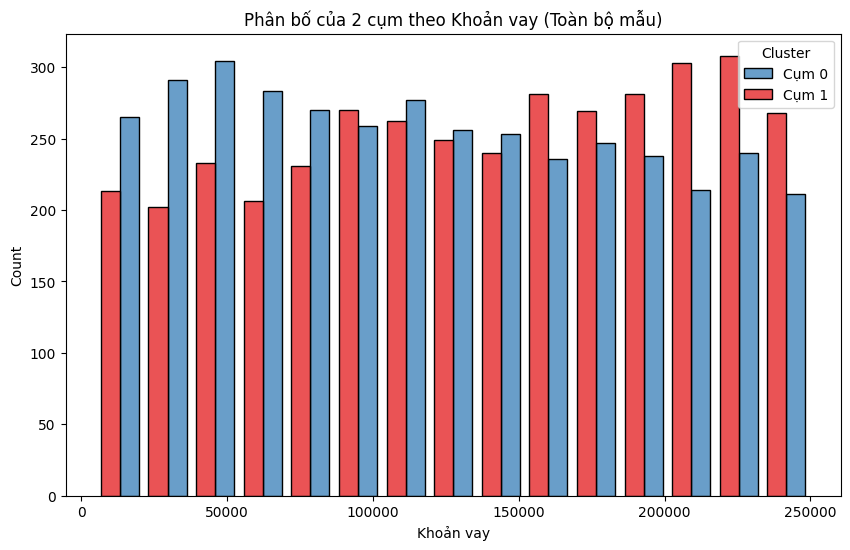

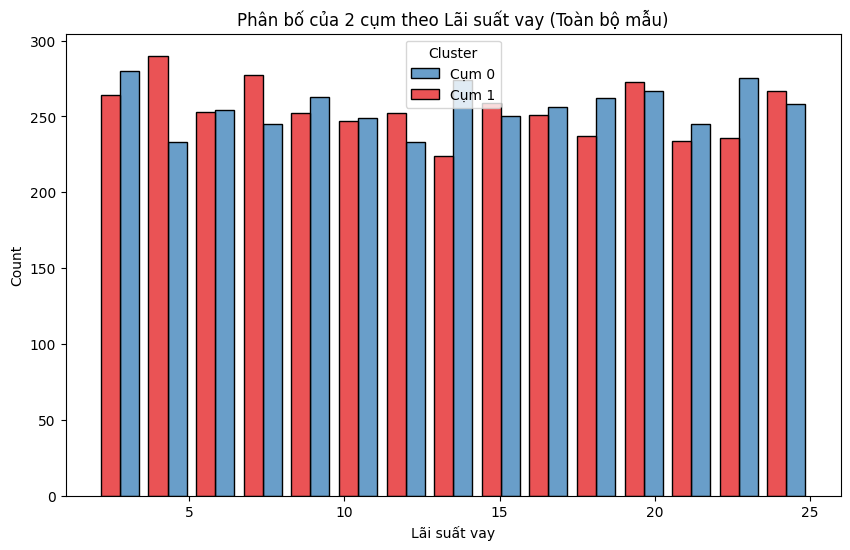

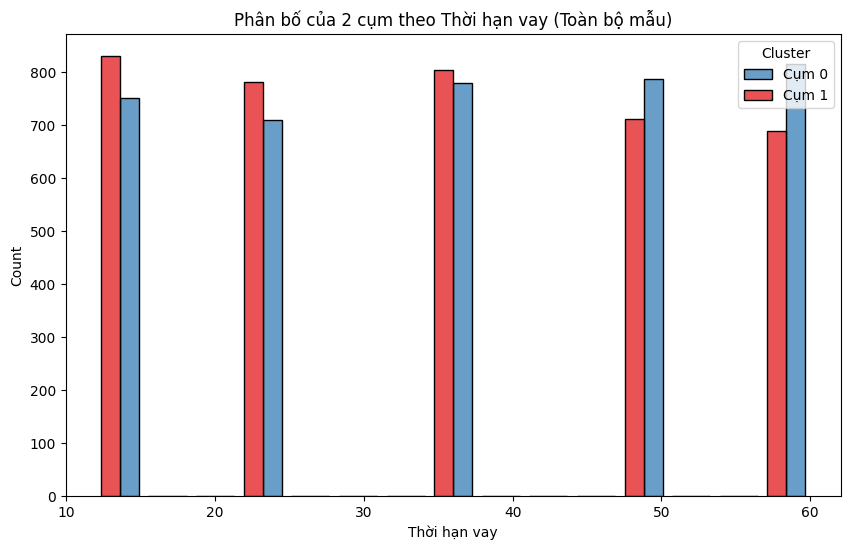

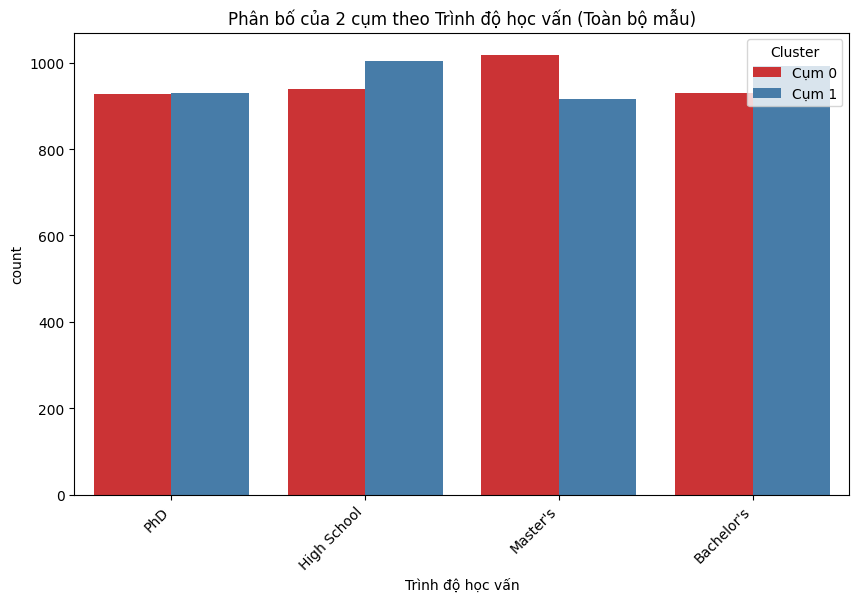

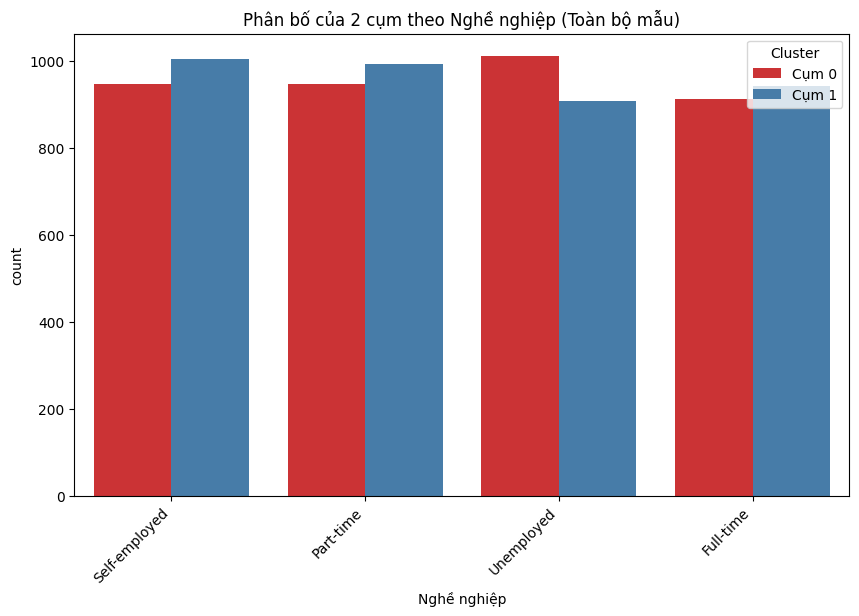

In [ ]:
from sklearn.metrics import silhouette_score
numerical_cols = ['Tuổi', 'Thu nhập', 'Khoản vay', 'Lãi suất vay', 'Thời hạn vay']

X_cluster_data = df_sample[numerical_cols].copy()
scaler_km = StandardScaler()
X_cluster_scaled = scaler_km.fit_transform(X_cluster_data)

silhouette_scores = {}
inertia_scores = []
K_range = range(2, 6)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    score = silhouette_score(X_cluster_scaled, kmeans.labels_)
    silhouette_scores[k] = score
    inertia_scores.append(kmeans.inertia_)

    print(f"Silhouette Score cho K={k}: {score:.4f}")

K_best_silhouette = max(silhouette_scores, key=silhouette_scores.get)
K_final = 2
plt.figure(figsize=(15, 6))
plt.suptitle(f"Đánh giá Mô hình K-Means: K={K_final} (Tổng mẫu)", fontsize=16)


# 3. ÁP DỤNG K-MEANS VỚI K=2
kmeans_model = KMeans(n_clusters=K_final, random_state=42, n_init=10)
clusters = kmeans_model.fit_predict(X_cluster_scaled)
df_sample['Cluster'] = clusters

# 4. PHÂN TÍCH ĐẶC ĐIỂM CÁC CỤM
print(f"\n[Phân tích] Trung bình các biến trong {K_final} cụm:")
cluster_analysis = df_sample.groupby('Cluster')[['Tuổi', 'Thu nhập', 'Khoản vay', 'Lãi suất vay', 'Thời hạn vay']].mean()
cluster_analysis['Tỷ lệ Vỡ nợ (Avg)'] = df_sample.groupby('Cluster')['Khả năng vỡ nợ'].apply(lambda x: (x.astype(int)).mean())
print(cluster_analysis.to_markdown(floatfmt=".2f"))

# 5. TRỰC QUAN HÓA PHÂN BỐ
variables_to_plot = [
    'Tuổi', 'Thu nhập', 'Khoản vay', 'Lãi suất vay', 'Thời hạn vay',
    'Trình độ học vấn', 'Nghề nghiệp'
]

for col in variables_to_plot:
    plt.figure(figsize=(10, 6))

    if col in numerical_cols:
        sns.histplot(data=df_sample, x=col, hue='Cluster', multiple="dodge", shrink=0.8,
                     bins=15, palette='Set1', edgecolor='black')
        plt.title(f'Phân bố của {K_final} cụm theo {col} (Toàn bộ mẫu)')
    else:
        sns.countplot(data=df_sample, x=col, hue='Cluster', palette='Set1')
        plt.title(f'Phân bố của {K_final} cụm theo {col} (Toàn bộ mẫu)')
        plt.xticks(rotation=45, ha='right')

    plt.legend(title='Cluster', labels=[f'Cụm {i}' for i in range(K_final)])
    plt.show()